In [1]:
import torch
from torch.autograd import grad
import torch.nn as nn
from numpy import genfromtxt
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

ebola_data = genfromtxt('ebola.csv', delimiter=',') #in the form of [t, S, E, I, H, F, R]

torch.manual_seed(1234)

In [2]:
%%time

PATH = 'ebola' 

class DINN(nn.Module):
    def __init__(self, t, S_data, E_data, I_data, H_data, F_data, R_data): 
        super(DINN, self).__init__()
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch 
        self.S = torch.tensor(S_data) 
        self.E = torch.tensor(E_data) 
        self.I = torch.tensor(I_data) 
        self.H = torch.tensor(H_data) 
        self.F = torch.tensor(F_data) 
        self.R = torch.tensor(R_data)         

        self.N = torch.tensor(470000, requires_grad=False)
        self.losses = [] #keep the losses
        self.save = 2 #which file to save to
  
        #learnable parameters
        self.beta1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_h_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_f_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.alpha_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma_h_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.theta1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma_i_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.delta1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma_d_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.delta2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma_f_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma_ih_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma_dh_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        

        #matrices (x6 for T,I,V) for the gradients
        self.m1 = torch.zeros((len(self.t), 6)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 6)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 6)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 6)); self.m1[:, 3] = 1
        self.m5 = torch.zeros((len(self.t), 6)); self.m2[:, 4] = 1
        self.m6 = torch.zeros((len(self.t), 6)); self.m3[:, 5] = 1

        #values for norm
        self.S_max = max(self.S)
        self.E_max = max(self.E)
        self.I_max = max(self.I)
        self.H_max = max(self.H)
        self.F_max = max(self.F)
        self.R_max = max(self.R)

        self.S_min = min(self.S)
        self.E_min = min(self.E)
        self.I_min = min(self.I)
        self.H_min = min(self.H)
        self.F_min = min(self.F)
        self.R_min = min(self.R)

        #normalize 
        self.S_hat = (self.S - self.S_min) / (self.S_max - self.S_min)
        self.E_hat = (self.E - self.E_min) / (self.E_max - self.E_min)
        self.I_hat = (self.I - self.I_min) / (self.I_max - self.I_min)
        self.H_hat = (self.H - self.H_min) / (self.H_max - self.H_min)
        self.F_hat = (self.F - self.F_min) / (self.F_max - self.F_min)
        self.R_hat = (self.R - self.R_min) / (self.R_max - self.R_min)

        #NN
        self.net_ebola = self.Net_ebola()
        self.params = list(self.net_ebola.parameters())
        self.params.extend(list([self.beta1_tilda, self.beta_h_tilda, self.beta_f_tilda, self.alpha_tilda, self.gamma_h_tilda, self.theta1_tilda, self.gamma_i_tilda, self.delta1_tilda, self.gamma_d_tilda, self.delta2_tilda, self.gamma_f_tilda, self.gamma_ih_tilda, self.gamma_dh_tilda]))

        
    #force parameters to be in a range
    @property
    def beta1(self):
        return torch.tanh(self.beta1_tilda) * 0.03 + 3.53

    @property
    def beta_h(self):
        return torch.tanh(self.beta_h_tilda) * 0.001 + 0.012

    @property
    def beta_f(self):
        return torch.tanh(self.beta_f_tilda) * 0.005 + 0.46

    @property
    def alpha(self):
        return torch.tanh(self.alpha_tilda) * 0.008 + 0.08

    @property
    def gamma_h(self):
        return torch.tanh(self.gamma_h_tilda) * 0.003 + 0.25

    @property
    def theta1(self):
        return torch.tanh(self.theta1_tilda) * 0.007 + 0.65

    @property
    def gamma_i(self):
        return torch.tanh(self.gamma_i_tilda) * 0.01 + 0.1

    @property
    def delta1(self):
        return torch.tanh(self.delta1_tilda) * 0.005 + 0.47

    @property
    def gamma_d(self):
        return torch.tanh(self.gamma_d_tilda) * 0.002 + 0.12

    @property
    def delta2(self):
        return torch.tanh(self.delta2_tilda) * 0.005 + 0.42

    @property
    def gamma_f(self):
        return torch.tanh(self.gamma_f_tilda) * 0.05 + 0.5

    @property
    def gamma_ih(self):
        return torch.tanh(self.gamma_ih_tilda) * 0.001 + 0.082

    @property
    def gamma_dh(self):
        return torch.tanh(self.gamma_dh_tilda) * 0.001 + 0.07
    

    #nets
    class Net_ebola(nn.Module): # input = [t]
        def __init__(self):
            super(DINN.Net_ebola, self).__init__()
            self.fc1=nn.Linear(1, 20) #takes t's
            self.fc2=nn.Linear(20, 20)
            self.fc3=nn.Linear(20, 20)
            self.fc4=nn.Linear(20, 20)
            self.fc5=nn.Linear(20, 20)
            self.fc6=nn.Linear(20, 20)
            self.fc7=nn.Linear(20, 20)
            self.fc8=nn.Linear(20, 20)
            self.out=nn.Linear(20, 6) #outputs S, E, I, H, F, R

        def forward(self, t):
            ebola=F.relu(self.fc1(t))
            ebola=F.relu(self.fc2(ebola))
            ebola=F.relu(self.fc3(ebola))
            ebola=F.relu(self.fc4(ebola))
            ebola=F.relu(self.fc5(ebola))
            ebola=F.relu(self.fc6(ebola))
            ebola=F.relu(self.fc7(ebola))
            ebola=F.relu(self.fc8(ebola))
            ebola=self.out(ebola)
            return ebola    

    def net_f(self, t_batch):      

        ebola_hat = self.net_ebola(t_batch)

        S_hat, E_hat, I_hat, H_hat, F_hat, R_hat = ebola_hat[:,0], ebola_hat[:,1], ebola_hat[:,2], ebola_hat[:,3], ebola_hat[:,4], ebola_hat[:,5]

        #S_t
        ebola_hat.backward(self.m1, retain_graph=True)
        S_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #E_t
        ebola_hat.backward(self.m2, retain_graph=True)
        E_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #I_t
        ebola_hat.backward(self.m3, retain_graph=True)
        I_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #H_t
        ebola_hat.backward(self.m4, retain_graph=True)
        H_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #F_t
        ebola_hat.backward(self.m5, retain_graph=True)
        F_hat_t = self.t.grad.clone()
        self.t.grad.zero_()
        
        #R_t
        ebola_hat.backward(self.m6, retain_graph=True)
        R_hat_t = self.t.grad.clone()
        self.t.grad.zero_()
        
        #unnormalize
        S = self.S_min + (self.S_max - self.S_min) * S_hat
        E = self.E_min + (self.E_max - self.E_min) * E_hat
        I = self.I_min + (self.I_max - self.I_min) * I_hat
        H = self.H_min + (self.H_max - self.H_min) * H_hat
        F = self.F_min + (self.F_max - self.F_min) * F_hat
        R = self.R_min + (self.R_max - self.R_min) * R_hat

        f1_hat = S_hat_t - (-1/self.N * (self.beta1 * S * I + self.beta_h * S * H + self.beta_f * S * F)) / (self.S_max - self.S_min) 
        f2_hat = E_hat_t - (1/self.N * (self.beta1 * S * I + self.beta_h * S * H + self.beta_f * S * F) - self.alpha * E) / (self.E_max - self.E_min) 
        f3_hat = I_hat_t - (self.alpha * E - (self.gamma_h * self.theta1 + self.gamma_i * (1-self.theta1)*(1-self.delta1) + self.gamma_d * (1-self.theta1) * self.delta1) * I) / (self.I_max - self.I_min) 
        f4_hat = H_hat_t - (self.gamma_h * self.theta1 * I - (self.gamma_dh * self.delta2 + self.gamma_ih * (1-self.delta2)) * H) / (self.H_max - self.H_min)  
        f5_hat = F_hat_t - (self.gamma_d * (1-self.theta1) * self.delta1 * I + self.gamma_dh * self.delta2 * H - self.gamma_f * F) / (self.F_max - self.F_min) 
        f6_hat = R_hat_t - (self.gamma_i * (1-self.theta1) * (1-self.delta1) * I + self.gamma_ih * (1-self.delta2) * H + self.gamma_f * F) / (self.R_max - self.R_min) 

        return f1_hat, f2_hat, f3_hat, f4_hat, f5_hat, f6_hat, S_hat, E_hat, I_hat, H_hat, F_hat, R_hat
    
    def load(self):
      # Load checkpoint
      try:
        checkpoint = torch.load(PATH + str(self.save)+'.pt') 
        print('\nloading pre-trained model...')
        self.load_state_dict(checkpoint['model'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        self.losses = checkpoint['losses']
        print('loaded previous loss: ', loss)
      except RuntimeError :
          print('changed the architecture, ignore')
          pass
      except FileNotFoundError:
          pass

    def train(self, n_epochs):
      #try loading
      self.load()

      #train
      print('\nstarting training...\n')
      
      for epoch in range(n_epochs):
        #lists to hold the output (maintain only the final epoch)
        S_pred_list= []
        E_pred_list= []
        I_pred_list= []
        H_pred_list= []
        F_pred_list= []
        R_pred_list= []
        
        f1, f2, f3, f4, f5, f6, S_pred, E_pred, I_pred, H_pred, F_pred, R_pred = self.net_f(self.t_batch)
        self.optimizer.zero_grad()

        S_pred_list.append(self.S_min + (self.S_max - self.S_min) * S_pred)
        E_pred_list.append(self.E_min + (self.E_max - self.E_min) * E_pred)
        I_pred_list.append(self.I_min + (self.I_max - self.I_min) * I_pred)
        H_pred_list.append(self.H_min + (self.H_max - self.H_min) * H_pred)
        F_pred_list.append(self.F_min + (self.F_max - self.F_min) * F_pred)
        R_pred_list.append(self.R_min + (self.R_max - self.R_min) * R_pred)

        loss = (
              torch.mean(torch.square(self.S_hat - S_pred)) + torch.mean(torch.square(self.I_hat - I_pred)) + torch.mean(torch.square(self.E_hat - E_pred)) + 
              torch.mean(torch.square(self.H_hat - H_pred)) + torch.mean(torch.square(self.F_hat - F_pred)) + torch.mean(torch.square(self.R_hat - R_pred)) + 
              torch.mean(torch.square(f1)) + torch.mean(torch.square(f2)) + torch.mean(torch.square(f3)) +
              torch.mean(torch.square(f4)) + torch.mean(torch.square(f5)) + torch.mean(torch.square(f6)) 
               )
        loss.backward()

        self.optimizer.step()
        self.scheduler.step() 
        #self.scheduler.step(loss) 

        self.losses.append(loss.item())

        if epoch % 1000 == 0:          
          print('\nEpoch ', epoch)

        #loss + model parameters update
        if epoch % 4000 == 9999:
          #checkpoint save every 1000 epochs if the loss is lower
          print('\nSaving model... Loss is: ', loss)
          torch.save({
              'epoch': epoch,
              'model': self.state_dict(),
              'optimizer_state_dict': self.optimizer.state_dict(),
              'scheduler': self.scheduler.state_dict(),
              'loss': loss,
              'losses': self.losses,
              }, PATH + str(self.save)+'.pt')
          if self.save % 2 > 0: #its on 3
            self.save = 2 #change to 2
          else: #its on 2
            self.save = 3 #change to 3

          print('epoch: ', epoch)
          print('beta1: (goal 3.532)', self.beta1)
          print('\nbeta_h: (goal 0.012)', self.beta_h)
          print('\nbeta_f: (goal 0.462): ', self.beta_f)
          print('\ntheta1: (goal 0.65): ', self.theta1)
          print('\ndelta2 (goal 0.42): ', self.delta2)
          print('\ngamma_f (goal 0.5): ', self.gamma_f)
          print('#################################')
        
      #plot
      plt.plot(self.losses, color = 'teal')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      return S_pred_list, E_pred_list, I_pred_list, H_pred_list, F_pred_list, R_pred_list


CPU times: user 95 µs, sys: 1e+03 ns, total: 96 µs
Wall time: 99.9 µs



loading pre-trained model...
loaded previous loss:  tensor(0.0032, dtype=torch.float64, requires_grad=True)

starting training...


Epoch  0
CPU times: user 4.84 s, sys: 851 ms, total: 5.69 s
Wall time: 5.7 s


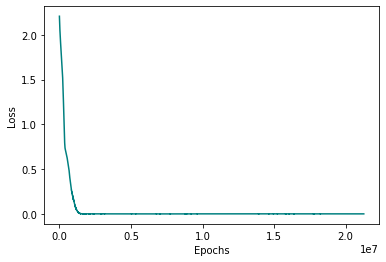

In [3]:
%%time

#this worked best
dinn = DINN(ebola_data[0], ebola_data[1], ebola_data[2], ebola_data[3], ebola_data[4], ebola_data[5], ebola_data[6]) #t,S, E, I, H, F, R

learning_rate = 1e-5
optimizer = optim.Adam(dinn.params, lr = learning_rate)
dinn.optimizer = optimizer

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(dinn.optimizer, factor=0.99, patience = 5000, verbose=True)
#scheduler = torch.optim.lr_scheduler.CyclicLR(dinn.optimizer, base_lr=1e-7, max_lr=1e-5, step_size_up=20000, mode="triangular2", cycle_momentum=False)
scheduler = torch.optim.lr_scheduler.CyclicLR(dinn.optimizer, base_lr=1e-7, max_lr=1e-3, step_size_up=1000, mode="exp_range", gamma=0.85, cycle_momentum=False)

dinn.scheduler = scheduler

try: 
  S_pred_list, E_pred_list, I_pred_list, H_pred_list, F_pred_list, R_pred_list = dinn.train(1) #train
except EOFError:
  if dinn.save == 2:
    dinn.save = 3
    S_pred_list, E_pred_list, I_pred_list, H_pred_list, F_pred_list, R_pred_list = dinn.train(1) #train
  elif dinn.save == 3:
    dinn.save = 2
    S_pred_list, E_pred_list, I_pred_list, H_pred_list, F_pred_list, R_pred_list = dinn.train(1) #train

Text(0, 0.5, 'Loss')

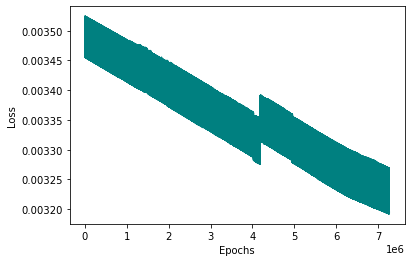

In [4]:
plt.plot(dinn.losses[14000000:], color = 'teal')
plt.xlabel('Epochs')
plt.ylabel('Loss')

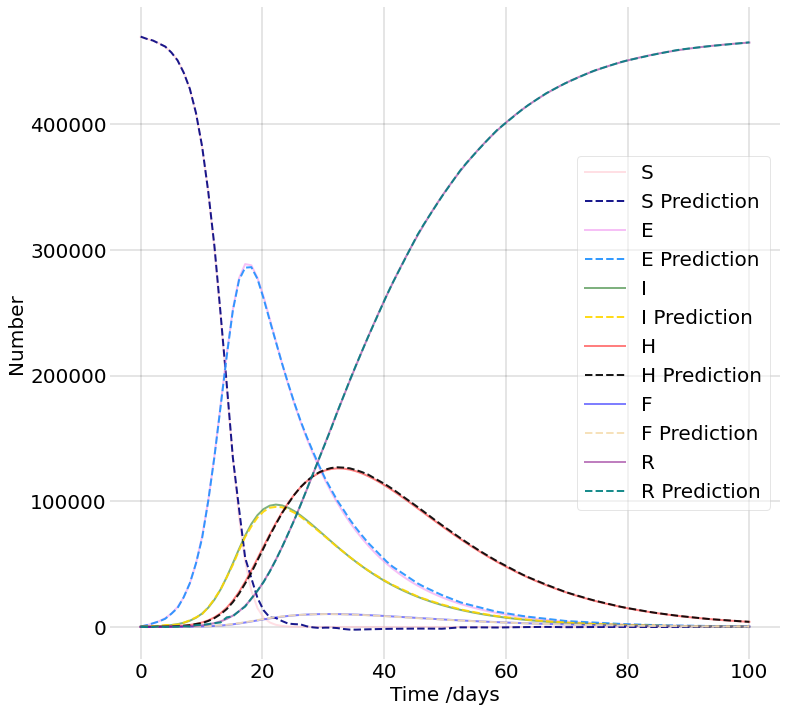

In [5]:
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_facecolor('xkcd:white')

ax.plot(ebola_data[0], ebola_data[1], 'pink', alpha=0.5, lw=2, label='S')
ax.plot(ebola_data[0], S_pred_list[0].detach().numpy(), 'navy', alpha=0.9, lw=2, label='S Prediction', linestyle='dashed')

ax.plot(ebola_data[0], ebola_data[2], 'violet', alpha=0.5, lw=2, label='E')
ax.plot(ebola_data[0], E_pred_list[0].detach().numpy(), 'dodgerblue', alpha=0.9, lw=2, label='E Prediction', linestyle='dashed')

ax.plot(ebola_data[0], ebola_data[3], 'darkgreen', alpha=0.5, lw=2, label='I')
ax.plot(ebola_data[0], I_pred_list[0].detach().numpy(), 'gold', alpha=0.9, lw=2, label='I Prediction', linestyle='dashed')

ax.plot(ebola_data[0], ebola_data[4], 'red', alpha=0.5, lw=2, label='H')
ax.plot(ebola_data[0], H_pred_list[0].detach().numpy(), 'black', alpha=0.9, lw=2, label='H Prediction', linestyle='dashed')

ax.plot(ebola_data[0], ebola_data[5], 'blue', alpha=0.5, lw=2, label='F')
ax.plot(ebola_data[0], F_pred_list[0].detach().numpy(), 'wheat', alpha=0.9, lw=2, label='F Prediction', linestyle='dashed')

ax.plot(ebola_data[0], ebola_data[6], 'purple', alpha=0.5, lw=2, label='R')
ax.plot(ebola_data[0], R_pred_list[0].detach().numpy(), 'teal', alpha=0.9, lw=2, label='R Prediction', linestyle='dashed')


ax.set_xlabel('Time /days',size = 20)
ax.set_ylabel('Number',size = 20)
#ax.set_ylim([-1,50])
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
plt.xticks(size = 20)
plt.yticks(size = 20)
ax.grid(b=True, which='major', c='black', lw=0.2, ls='-')
legend = ax.legend(prop={'size':20})
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.savefig('ebola.pdf')
plt.show()

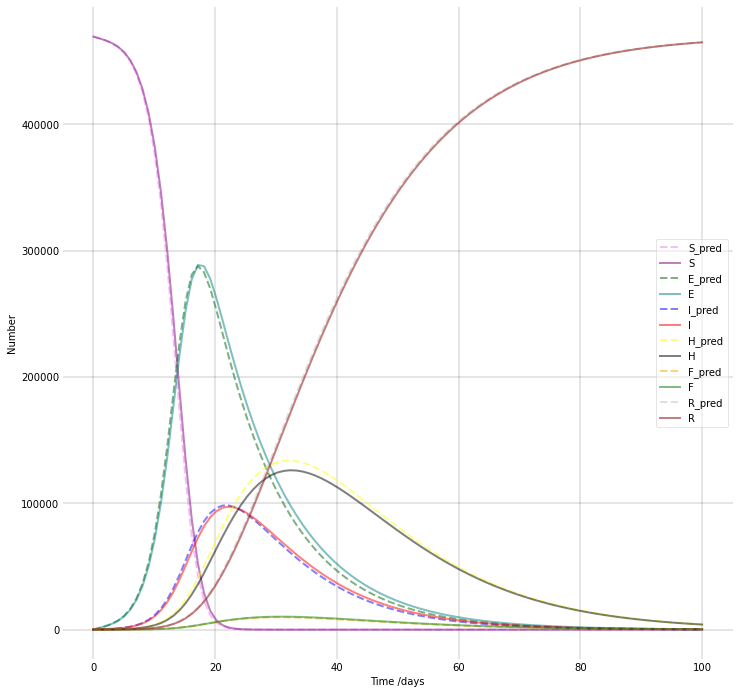

In [6]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Initial conditions
E0 = 0
I0 = 425
H0 = 0
F0 = 0
R0 = 0
N = 470000
S0 = N - I0

# A grid of time points (in days)
t = np.linspace(0, 100, 100) 

#parameters
beta1 = dinn.beta1
beta_h = dinn.beta_h
beta_f = dinn.beta_f
alpha = dinn.alpha
gamma_h = dinn.gamma_h
theta1 = dinn.theta1
gamma_i = dinn.gamma_i
delta1 = dinn.delta1
gamma_d = dinn.gamma_d
delta2 = dinn.delta2
gamma_f = dinn.gamma_f
gamma_ih  = 1 / ( (1/dinn.gamma_d) + (1/dinn.gamma_h))
gamma_dh = 1 / ( (1/dinn.gamma_i) + (1/dinn.gamma_h))

# The SIR model differential equations.
def deriv(y, t, N, beta1, beta_h, beta_f, alpha, gamma_h, theta1, gamma_i, delta1, gamma_d, delta2, gamma_f, gamma_ih , gamma_dh):
    S, E, I, H, F, R  = y
    dSdt = -1/N * (beta1 * S * I + beta_h * S * H + beta_f * S * F)
    dEdt = 1/N * (beta1 * S * I + beta_h * S * H + beta_f * S * F) - alpha * E
    dIdt = alpha * E - (gamma_h * theta1 + gamma_i * (1-theta1)*(1-delta1) + gamma_d * (1-theta1) * delta1) * I
    dHdt = gamma_h * theta1 * I - (gamma_dh * delta2 + gamma_ih * (1-delta2)) * H
    dFdt = gamma_d * (1-theta1) * delta1 * I + gamma_dh * delta2 * H - gamma_f * F
    dRdt = gamma_i * (1-theta1) * (1-delta1) * I + gamma_ih * (1-delta2) * H + gamma_f * F

    return dSdt, dEdt, dIdt, dHdt, dFdt, dRdt


# Initial conditions vector
y0 = S0, E0, I0, H0, F0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta1, beta_h, beta_f, alpha, gamma_h, theta1, gamma_i, delta1, gamma_d, delta2, gamma_f, gamma_ih , gamma_dh))
S, E, I, H, F, R = ret.T


# Plot the data on two separate curves for S(t), I(t)
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_facecolor('xkcd:white')

ax.plot(t, S, 'violet', alpha=0.5, lw=2, label='S_pred', linestyle='dashed')
ax.plot(ebola_data[0], ebola_data[1], 'purple', alpha=0.5, lw=2, label='S')

ax.plot(t, E, 'darkgreen', alpha=0.5, lw=2, label='E_pred', linestyle='dashed')
ax.plot(ebola_data[0], ebola_data[2], 'teal', alpha=0.5, lw=2, label='E')

ax.plot(t, I, 'blue', alpha=0.5, lw=2, label='I_pred', linestyle='dashed')
ax.plot(ebola_data[0], ebola_data[3], 'red', alpha=0.5, lw=2, label='I')

ax.plot(t, H, 'yellow', alpha=0.5, lw=2, label='H_pred', linestyle='dashed')
ax.plot(ebola_data[0], ebola_data[4], 'black', alpha=0.5, lw=2, label='H')

ax.plot(t, F, 'orange', alpha=0.5, lw=2, label='F_pred', linestyle='dashed')
ax.plot(ebola_data[0], ebola_data[5], 'green', alpha=0.5, lw=2, label='F')

ax.plot(t, R, 'silver', alpha=0.5, lw=2, label='R_pred', linestyle='dashed')
ax.plot(ebola_data[0], ebola_data[6], 'darkred', alpha=0.5, lw=2, label='R')

ax.set_xlabel('Time /days')
ax.set_ylabel('Number')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='black', lw=0.2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [7]:
#calculate relative MSE loss
import math

#SEIHFR

S_total_loss = 0
S_den = 0
E_total_loss = 0
E_den = 0
I_total_loss = 0
I_den = 0
H_total_loss = 0
H_den = 0
F_total_loss = 0
F_den = 0
R_total_loss = 0
R_den = 0

for timestep in range(len(t)):
  S_value = ebola_data[1][timestep] - S[timestep]
  S_total_loss += S_value**2
  S_den += (ebola_data[1][timestep])**2

  E_value = ebola_data[2][timestep] - E[timestep]
  E_total_loss += E_value**2
  E_den += (ebola_data[2][timestep])**2
  
  I_value = ebola_data[3][timestep] - I[timestep]
  I_total_loss += I_value**2
  I_den += (ebola_data[3][timestep])**2

  H_value = ebola_data[4][timestep] - H[timestep]
  H_total_loss += H_value**2
  H_den += (ebola_data[4][timestep])**2

  F_value = ebola_data[5][timestep] - F[timestep]
  F_total_loss += F_value**2
  F_den += (ebola_data[5][timestep])**2

  R_value = ebola_data[6][timestep] - R[timestep]
  R_total_loss += R_value**2
  R_den += (ebola_data[6][timestep])**2
  
S_total_loss = math.sqrt(S_total_loss/S_den)
E_total_loss = math.sqrt(E_total_loss/E_den)
I_total_loss = math.sqrt(I_total_loss/I_den)
H_total_loss = math.sqrt(H_total_loss/H_den)
F_total_loss = math.sqrt(F_total_loss/F_den)
R_total_loss = math.sqrt(R_total_loss/R_den)


print('S_total_loss: ', S_total_loss)
print('E_total_loss: ', E_total_loss)
print('I_total_loss: ', I_total_loss)
print('H_total_loss: ', H_total_loss)
print('F_total_loss: ', F_total_loss)
print('R_total_loss: ', R_total_loss)

S_total_loss:  0.022786995847905882
E_total_loss:  0.04860083467572867
I_total_loss:  0.04297943330125166
H_total_loss:  0.06132088632282767
F_total_loss:  0.052548629651301935
R_total_loss:  0.0052631547816651
